<a href="https://colab.research.google.com/github/hsantos1985/core_projects/blob/main/ANALISE_MUDANCAS_CLIMATICAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mudanças Climáticas

O objetio deste notebook, é criar um modelo que possa analisar a relação entre algumas variáveis e a temperatura.

Analisando como alterações nessas variáveis afetam as temperaturas futuras e como essas variáveis explicam as mudanças na temperatura.
Para tanto, será criado um modelo que possa prever a variável Temp usando MEI, CO2, CH4, N2O, CFC.11, CFC.12, TSI e Aerosol.

O arquivo [climate_change.csv](https://raw.githubusercontent.com/abnr/ml-data/main/climate_change.csv) tem dados climáticos de Maio de 1983 até Dezembro de 2008, com a variáveis:

* Year: o ano da observação.
* Month: o mês da observação.
* Temperature: a diferença em graus Celsius entre a média global de temperatura naquele período e um valor de referência. Dado proveniente da [Climatic Research Unit at the University of East Anglia](https://sites.uea.ac.uk/cru/).
* CO2, N2O, CH4, CFC.11, CFC.12: concentração atmosférica de dióxido de carbono (CO2), óxido nitroso (N2O), metano (CH4), triclorofluormetano (CCl3F, conhecido como CFC-11) e diclorofluormetano (CCl2F2, conhecido como CFC-12). Esses dados foram coletados da  [ESRL/NOAA Global Monitoring Division](http://www.esrl.noaa.gov/gmd/ccgg/data-products.html).
* Aerosols:  a media da profundidade óptica do aerosol estratosférico à 500 nm. Essa variável é ligada com a atividade vulcânica, já que essa atividade lança partículas na atmosfera que afetam o quanto da energia do sol é refletida novamente para o espaço. Esse dado é do [Godard Institute for Space Studies at NASA](http://data.giss.nasa.gov/modelforce/strataer/).
* TSI: o total da irradiãncia solar em W/m2 (a quantidade de energia solar depositada por unidade de área). Devido a manchas solares e outros fenômenos solares, essa quantidade de energia pode variar com o tempo. Dado proveniente do [SOLARIS-HEPPA](http://solarisheppa.geomar.de/solarisheppa/cmip5).
* MEI: multivariate El Nino Southern Oscillation index (MEI), uma medida de força do El Nino/La Nina. Dado do [ESRL/NOAA Physical Sciences Division](https://www.esrl.noaa.gov/psd/).


In [ ]:
#importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
from scipy import stats
from scipy.stats.stats import pearsonr
import scipy
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Datasets

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/abnr/ml-data/main/climate_change.csv')

In [ ]:
df.head()

,Year,Month,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,Temp
0,1983,5,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1,1983,6,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
2,1983,7,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
3,1983,8,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
4,1983,9,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149


In [ ]:
#separando os datasets em treino
#treino
df_treino=df.loc[df['Year']<=2006,:]
y_treino=df_treino['Temp']
x_treino=df_treino.drop(columns=['Year','Month','Temp'])

In [ ]:
x_treino.head()

,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols
0,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863
1,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794
2,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731
3,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673
4,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619


In [ ]:
#separando os datasets de teste
#teste
df_teste=df.loc[df['Year']>=2006,:]
y_teste=df_teste['Temp']
x_teste=df_teste.drop(columns=['Year','Month','Temp'])

In [ ]:
x_teste.head()

,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols
272,-0.471,381.35,1795.03,319.826,250.771,541.627,1365.8986,0.0034
273,-0.455,382.16,1786.41,319.947,250.484,541.273,1365.8728,0.0033
274,-0.591,382.66,1786.77,319.902,250.155,540.952,1365.7850,0.0032
275,-0.688,384.73,1801.19,319.815,249.989,540.741,1365.8058,0.0032
276,-0.036,384.98,1798.85,319.848,249.839,540.456,1365.9230,0.0030


#Inspeção de dados

In [ ]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 283
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      284 non-null    int64  
 1   Month     284 non-null    int64  
 2   MEI       284 non-null    float64
 3   CO2       284 non-null    float64
 4   CH4       284 non-null    float64
 5   N2O       284 non-null    float64
 6   CFC-11    284 non-null    float64
 7   CFC-12    284 non-null    float64
 8   TSI       284 non-null    float64
 9   Aerosols  284 non-null    float64
 10  Temp      284 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 26.6 KB


In [ ]:
df_treino.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,284.0,1994.661972,6.845996,1983.0000,1989.00000,1995.0000,2001.000000,2006.0000
Month,284.0,6.556338,3.446768,1.0000,4.00000,7.0000,10.000000,12.0000
MEI,284.0,0.341923,0.929639,-1.5860,-0.32300,0.3085,0.898000,3.0010
CO2,284.0,361.414261,11.439691,340.1700,352.31500,359.8900,370.585000,384.9800
CH4,284.0,1745.841479,45.669846,1629.8900,1716.34750,1758.6050,1781.637500,1808.1500
N2O,284.0,311.657225,4.758513,303.6770,307.65700,310.8495,316.129250,320.4510
CFC-11,284.0,252.487092,20.987671,191.3240,249.55775,260.3735,267.448000,271.4940
CFC-12,284.0,494.217546,59.046642,350.1130,462.54300,522.0890,540.972750,543.8130
TSI,284.0,1366.101437,0.401283,1365.4261,1365.75455,1366.0545,1366.399275,1367.3162
Aerosols,284.0,0.017721,0.030014,0.0016,0.00270,0.0062,0.014000,0.1494


In [ ]:
#verificando a existência de valores nulos
df_treino.isnull().sum().sort_values(ascending=True)

Year        0
Month       0
MEI         0
CO2         0
CH4         0
N2O         0
CFC-11      0
CFC-12      0
TSI         0
Aerosols    0
Temp        0
dtype: int64

In [ ]:
#checando a duplicdade das linhas
df_treino.duplicated().sum()

0

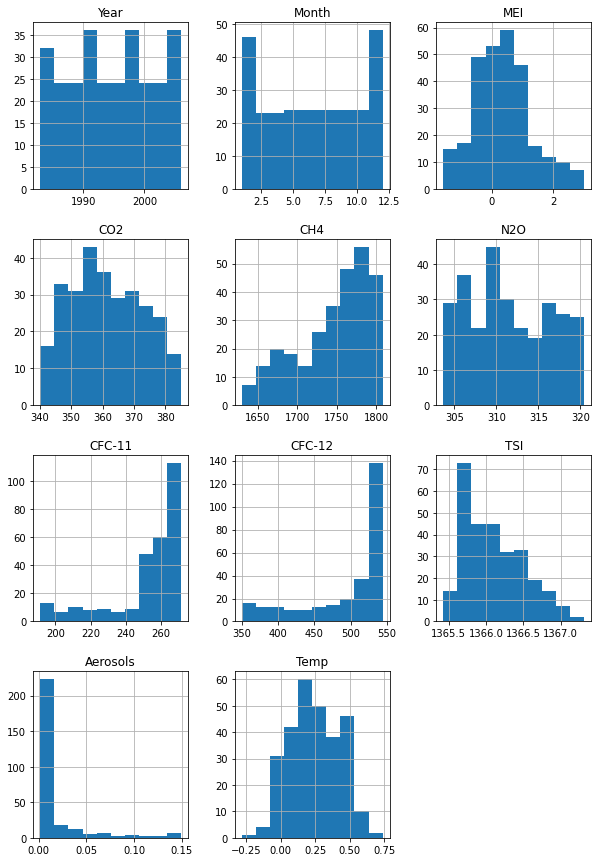

In [ ]:
#analisando o histograma das variáveis

df_treino.hist(figsize=(10,15))
plt.show();

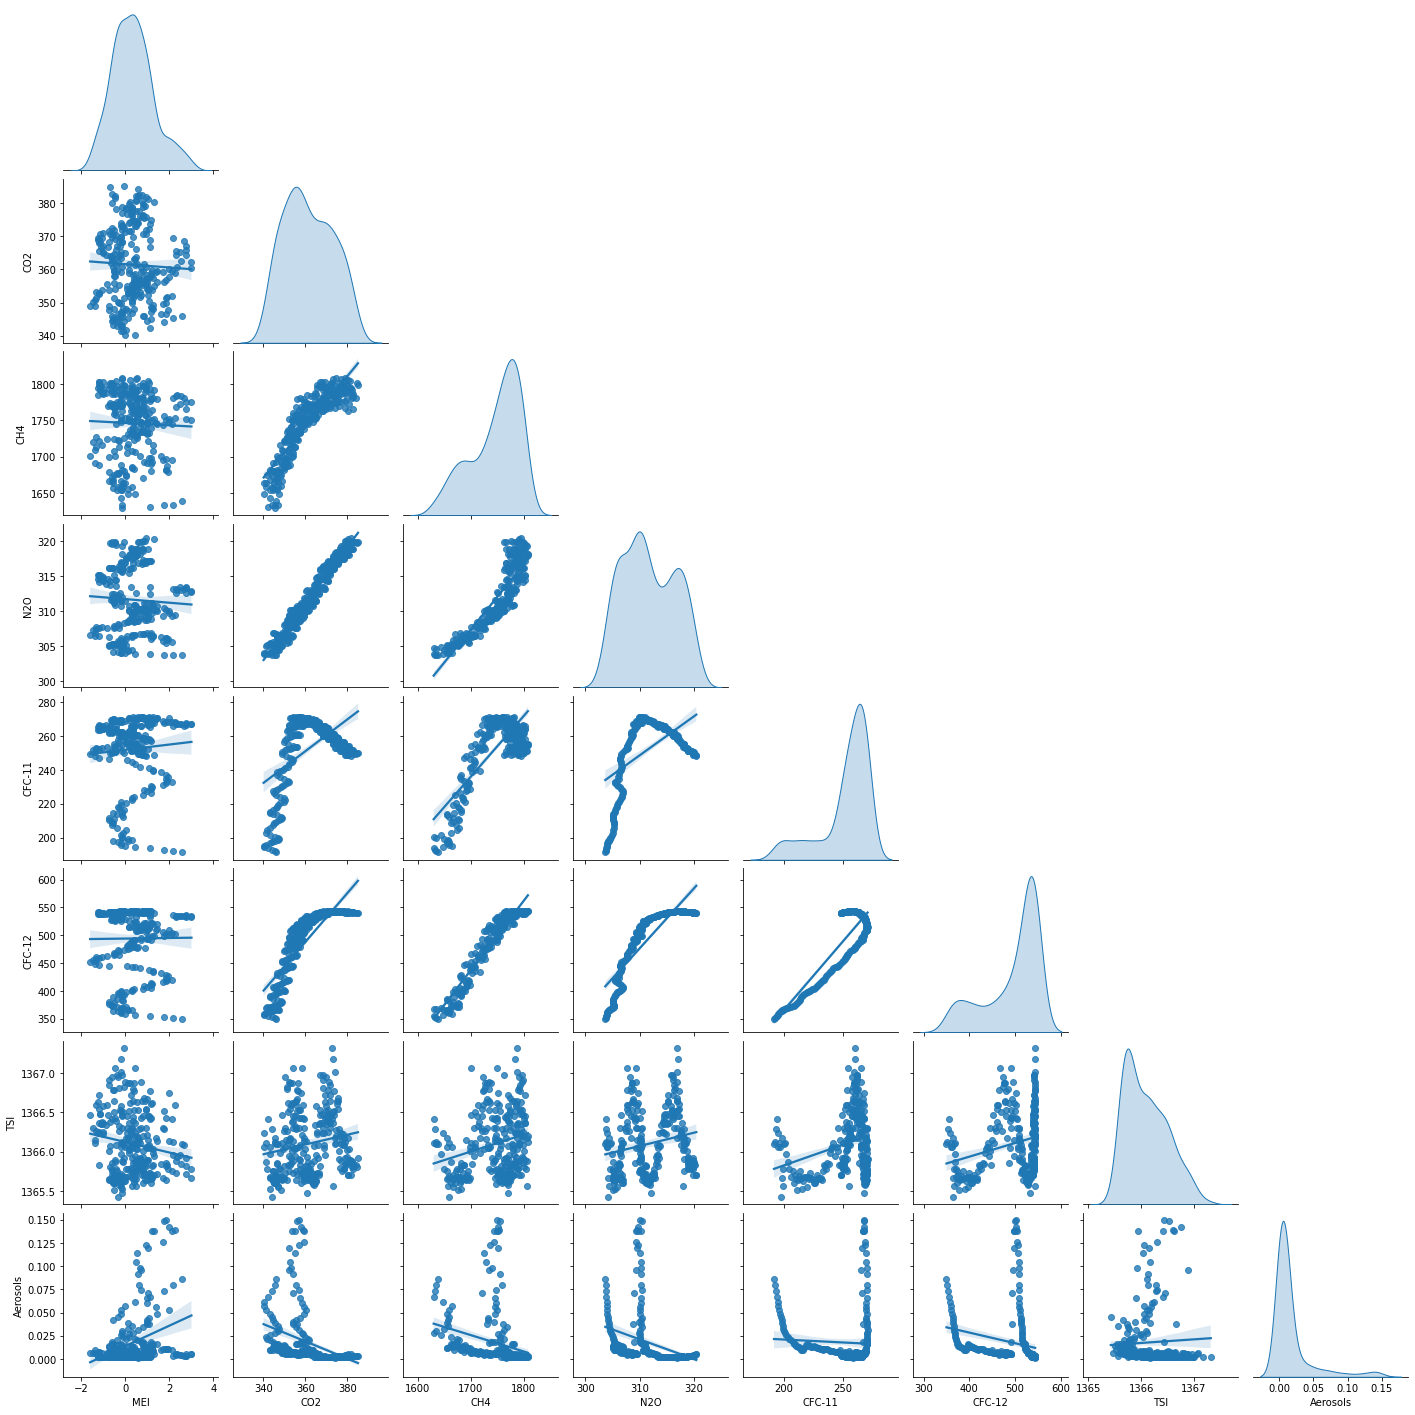

In [ ]:
#analisando graficamente as possíveis correlações entre as variáveis do dataset de treino
colunas=x_treino.columns
sns.pairplot(df_treino.loc[:,colunas],diag_kind='kde', kind='reg',corner=True);

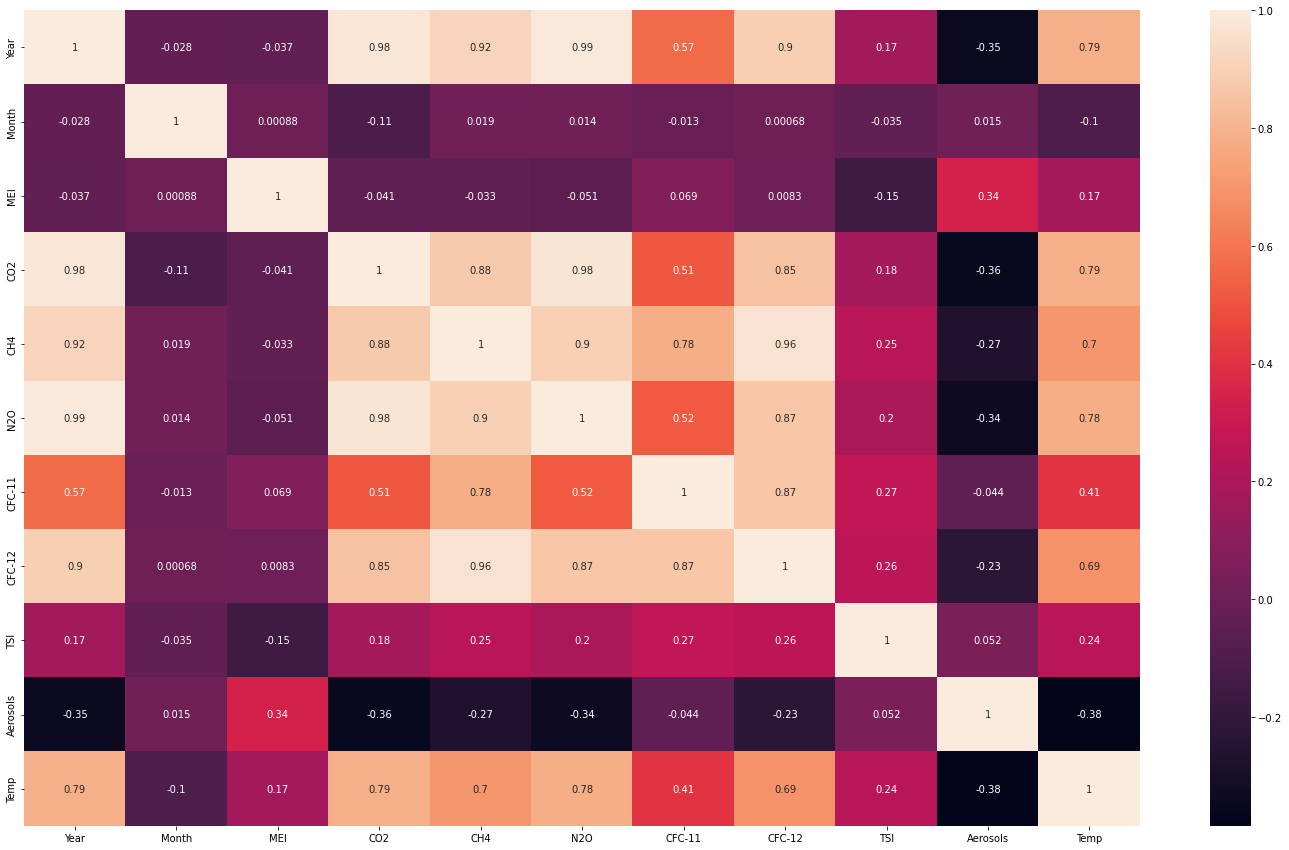

In [ ]:
#analisando a correlação entre as variáveis pelo heatmap
plt.figure(figsize=(25,15))
sns.heatmap(df_treino.corr(),annot=True)
plt.show();

#Criação do modelo

In [ ]:
#criando o modelo
x_treinoc=sm.add_constant(x_treino)
model=sm.OLS(y_treino,x_treinoc)
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     103.6
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.94e-78
Time:                        23:41:20   Log-Likelihood:                 280.10
No. Observations:                 284   AIC:                            -542.2
Df Residuals:                     275   BIC:                            -509.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -124.5943     19.887     -6.265      0.0

In [ ]:
#Como as variáveis CH4 e N2O possuem o p-value maior que 5%, aceita-se assim H0(As variáveis são iguais a 0)
#Cria-se um novo modelo tirando estas variáveis

In [ ]:
#criando novos datasets
#treino
df_treino2=df.loc[df['Year']<=2006,:]
y_treino2=df_treino2['Temp']
x_treino2=df_treino2.drop(columns=['Year','Month','Temp','CH4','N2O'])

#teste
df_teste2=df.loc[df['Year']>=2006,:]
y_teste2=df_teste2['Temp']
x_teste2=df_teste2.drop(columns=['Year','Month','Temp','CH4','N2O'])

In [ ]:
#criando um novo modelo
x_treino2c=sm.add_constant(x_treino2)
model2=sm.OLS(y_treino2,x_treino2c)
results2=model2.fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     136.6
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           9.15e-80
Time:                        23:41:56   Log-Likelihood:                 278.16
No. Observations:                 284   AIC:                            -542.3
Df Residuals:                     277   BIC:                            -516.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -122.2527     19.913     -6.139      0.0

In [ ]:
#criando as variaveis predict
x_testec=sm.add_constant(x_teste2)
y_teste_p=results2.predict(x_testec)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
x_treino2_c = sm.add_constant(x_treino2)
y_treino_p=results2.predict(x_treino2_c)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#MSE e MAPE para variáveis de treino
mse_treino2 = mean_squared_error(y_treino2, y_treino_p)
mape=np.sqrt(mse_treino2)
print(mse_treino2,mape)

0.008256453693186942 0.09086503008961666


In [ ]:
#MSE e MAPE para variáveis de teste
mse_teste2 = mean_squared_error(y_teste2, y_teste_p)
mape_teste=np.sqrt(mse_teste2)
print(mse_teste2,mape_teste)

0.007661867214088063 0.08753209248091846


In [ ]:
#Pelos testes de MSE e MAPE para os datasets de treino e teste, verifica-se que os resultados estão próximos

# Premissas do modelo

# 1 Linearidade
Variável target pode ser estimada através da combinação linear entre as variáveis de entrada.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


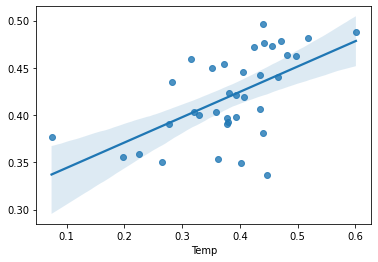

In [ ]:
sns.regplot(y_teste2, y_teste_p);

In [ ]:
#pelo gráfico não é possível afirmr que a variável Temp pode ser determinada pelas variáveis d eentrada

# 2 - Resíduos( diferença entre a resutado real e o previsto) tem médias iguais a 0
A regressão linear assume que o que não é capturado pelo modelo, os resíduos, tem média 0.

In [ ]:
results2.resid.mean(0)

1.587409781087856e-13

In [ ]:
#pelo resultado anterior. a diferença entre o resultado real e o previsto é igual a 0

# 3 - Sem multicolinariedade (forte)
As variáveis não podem ser fortemente correlacionadas entre si. Em outras palavras, não deve ser possível prever uma variável de entrada a partir de outra.

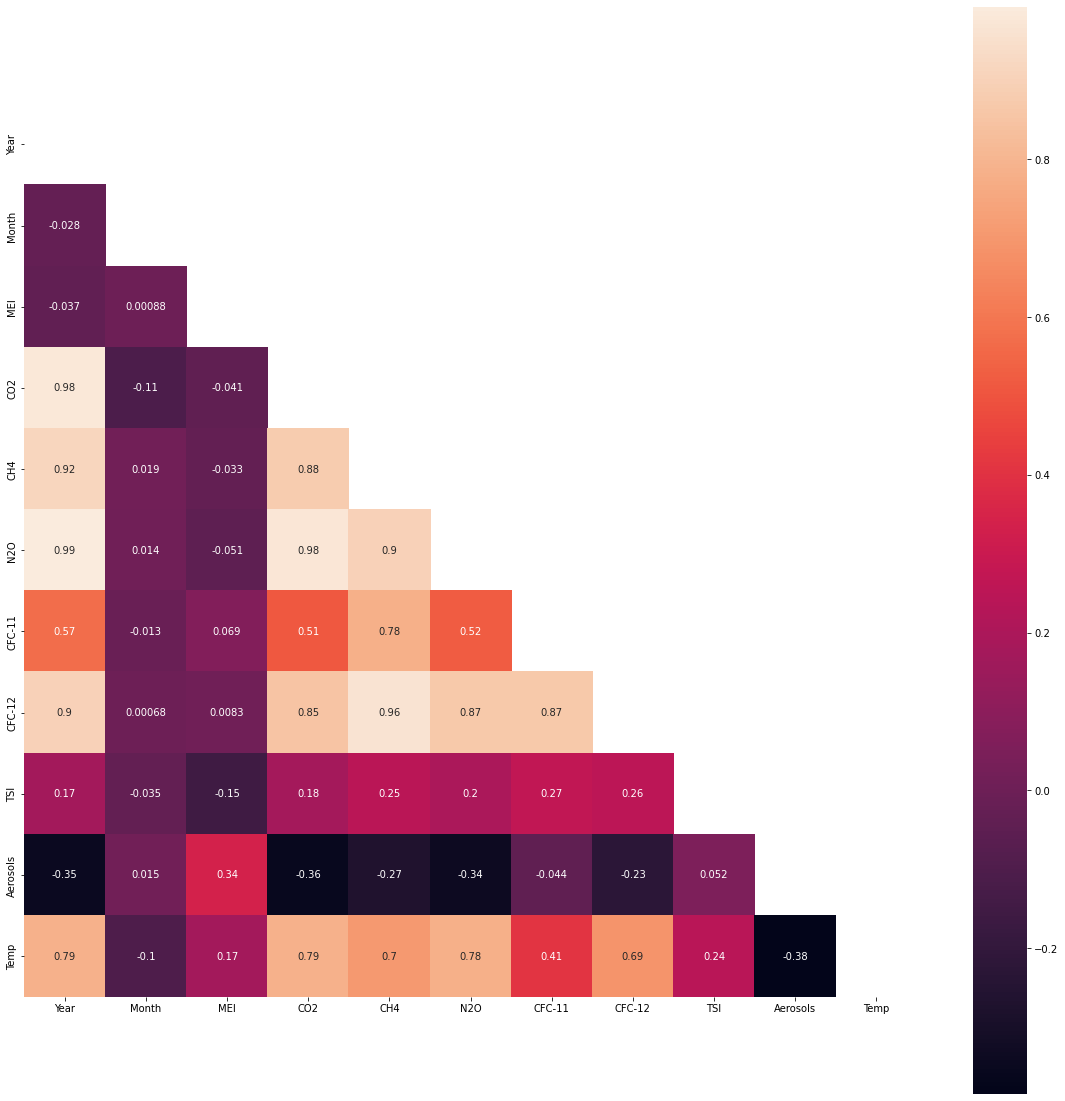

In [ ]:
from IPython.core.pylabtools import figsize
plt.subplots(figsize=(20,20))

sns.heatmap(df_treino2.corr(),mask = np.triu(df_treino2.corr()), annot= True, square = True);

In [ ]:
#Pelo heatmap anterior, percebe-se que existe correlação elevada considerando as variáveis de x_treino2

# 4 - Homecedasticidade dos resíduos
A regressão assume que os resíduos possuem variância igual. Quando a variância dos resíduos não é constante dizemos que possui heteroscedasticidade.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


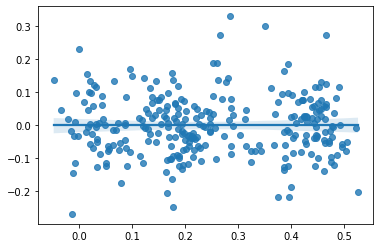

In [ ]:
y_pred=results2.predict(x_treino2_c)
sns.regplot( y_pred, results2.resid );

H0  do teste Goldfeld-Quandt assume que os resíduos são homoscedasticos.


In [ ]:
t, p, _ = sms.het_goldfeldquandt(results2.resid, x_treino2_c)
print(p)

0.27760897262953643


In [ ]:
#Pelo gráfico e pelo p-value calculado, verifica-se que os resíduos são homocedasticos, ou seja, a variância dos resíduos são constantes

# 5 - Resíduos não podem ser autocorrelacionados
Autocorrelação nos resíduos significa que o resíduo depende de valores anteriores dos resíduos. Durbin Watson Test A saída do teste é sempre entre 0 e 4, onde:

Valor igual a 2 significa que não tem autocorrelação nos resíduos. Valor < 2 indica correlação positiva nos resíduos. Valor > 2 indica correlação negativa nos resíduos.

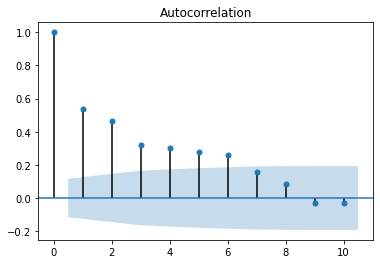

In [ ]:
acf = smt.graphics.plot_acf( results2.resid, lags=10, alpha=0.05 )
acf.show()

In [ ]:
#pelo gráfico anterior verifica-se que os resíduos são autocorrelacionados

#6 - Resíduos e variáveis não correlacionados
*Resíduos* correlacionados significa que os resíduos não são componentes totalmente aleatórios.

In [ ]:
for column in x_treino2.columns:
    corr_test = pearsonr( x_treino2[column], results2.resid )
    print( 'Variável: ', column, ' coef ', corr_test[0], 'pvalor', corr_test[1]  )

Variável:  MEI  coef  7.616043212754775e-14 pvalor 0.9999999999989356
Variável:  CO2  coef  -1.8461360912214175e-14 pvalor 0.9999999999997279
Variável:  CFC-11  coef  -6.885843891607513e-14 pvalor 0.9999999999990515
Variável:  CFC-12  coef  -4.9511176408723045e-14 pvalor 0.9999999999992929
Variável:  TSI  coef  3.202906689869778e-14 pvalor 0.9999999999995256
Variável:  Aerosols  coef  5.822523452964079e-14 pvalor 0.9999999999991925


In [ ]:
#Pela ordem de grandeza dos coeficientes, os resíduos não são correlacionados com as variáveis de entrada

#7 - Normalidade dos resíduos
Se os resíduos nao fore norais haverá problemas na determinação dos intervalos de confiança e o nível de significância dos coeficientes

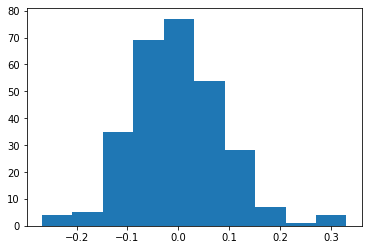

In [ ]:
plt.hist(results2.resid);

In [ ]:
from scipy.stats.morestats import shapiro
shapiro(results2.resid)

(0.9882131814956665, 0.020576898008584976)

In [ ]:
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     136.6
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           9.15e-80
Time:                        00:17:15   Log-Likelihood:                 278.16
No. Observations:                 284   AIC:                            -542.3
Df Residuals:                     277   BIC:                            -516.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -122.2527     19.913     -6.139      0.0

In [ ]:
#pelso resultados anteriores, verifica-se que os resíduos não são normais

#Conclusão

Pelos análises realizados verifica-se, que o modelo pode explicar a variação das variáveis em 72%.
Os resultados de MAPE e MSE das variáveis do dataset df_treino2 e df_teste2 são próximos
Em todas as premissas do modelo (results2) se tornaram favorábeis, exceto para a normalidade dos resíduos, os quais não são normais.
Desta maneira, conclui-se que o modelo é viável, podendo descartar a reprovação na premissa 7.
A inserção de outras variáveis do modelo poderia corrigir este fato, e ainda, aumantar o coefciente de determinação